## Assignment 23 - PROJECT 2
### ACD MDS (Mar 2018 batch) Student: K. Anandaranga

#### Predicting Player Rating

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sqlite3

In [3]:
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import math

from sklearn.tree import DecisionTreeRegressor

In [4]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\krishnam\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

### DESCRIPTIVE AND VISUAL ANALYSIS OF DATA

In [6]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [7]:
df.shape

(183978, 42)

#### Understanding the DEPENDENT VARIABLE - "overall_rating" that is to be predicted

In [8]:
df.overall_rating.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

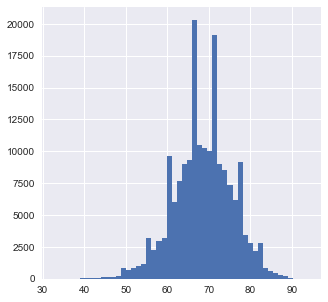

In [9]:
df.overall_rating.hist(bins=50, figsize=(5,5))
plt.show()

#### Player rating is spread between 33 to 94, with a median at 69, and mean = 68.64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

#### From the above: There are 4 CATEGORICAL columns and 38 NUMERICAL columns
#### Also, there are a few null values on some columns

In [11]:
df.dropna(axis=0, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 42 columns):
id                     180354 non-null int64
player_fifa_api_id     180354 non-null int64
player_api_id          180354 non-null int64
date                   180354 non-null object
overall_rating         180354 non-null float64
potential              180354 non-null float64
preferred_foot         180354 non-null object
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
accele

In [13]:
pd.set_option("display.precision", 2)

### Understanding the NUMERICAL COLUMNS

In [14]:
df.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,...,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00,180354.00
mean,91995.89,166822.13,137653.15,68.64,73.48,55.14,49.96,57.26,62.49,49.49,...,57.87,54.93,46.76,50.35,48.03,14.70,15.95,20.53,16.02,16.33
std,53092.66,52821.44,137599.74,7.03,6.58,17.25,19.04,16.48,14.17,18.25,...,15.15,15.56,21.23,21.50,21.59,16.84,15.84,21.14,16.07,17.19
min,1.00,2.00,2625.00,33.00,39.00,1.00,1.00,1.00,3.00,1.00,...,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00
25%,46074.25,156616.00,35451.00,64.00,69.00,45.00,34.00,49.00,57.00,35.00,...,49.00,45.00,25.00,29.00,25.00,7.00,8.00,8.00,8.00,8.00
50%,92003.50,183792.00,80291.00,69.00,74.00,59.00,53.00,60.00,65.00,52.00,...,60.00,57.00,50.00,56.00,53.00,10.00,11.00,12.00,11.00,11.00
75%,137935.75,200138.00,192841.00,73.00,78.00,68.00,65.00,68.00,72.00,64.00,...,69.00,67.00,66.00,69.00,67.00,13.00,15.00,15.00,15.00,15.00
max,183978.00,234141.00,750584.00,94.00,97.00,95.00,97.00,98.00,97.00,93.00,...,97.00,96.00,94.00,95.00,95.00,94.00,93.00,97.00,96.00,96.00


In [15]:
df.preferred_foot.value_counts()

right    136247
left      44107
Name: preferred_foot, dtype: int64

In [16]:
df.attacking_work_rate.value_counts()

medium    125070
high       42823
low         8569
None        3317
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64

In [17]:
df.defensive_work_rate.value_counts()

medium    130846
high       27041
low        18432
o           1328
1            421
2            334
ormal        317
3            243
5            231
7            207
0            188
6            179
9            143
4            116
es            94
tocky         86
ean           78
8             70
Name: defensive_work_rate, dtype: int64

#### Histogram of NUMERICAL COLUMNS

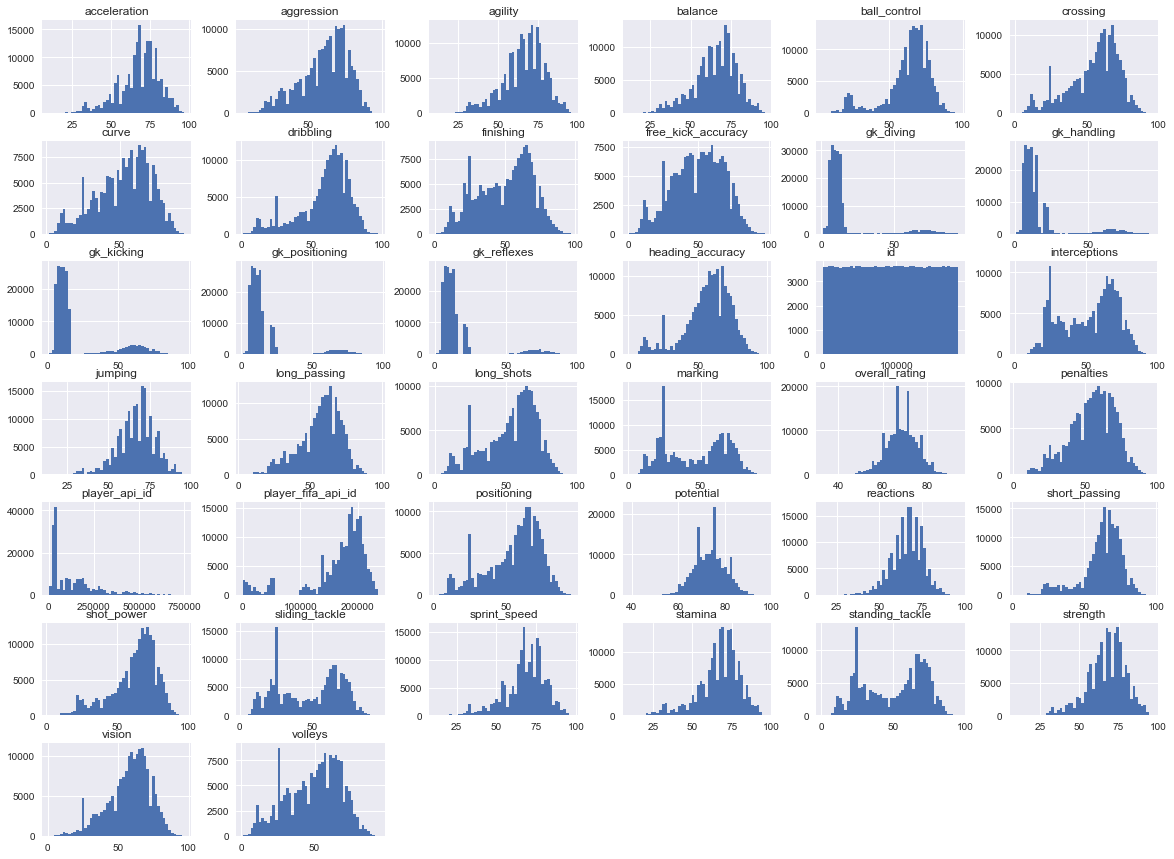

In [18]:
df.hist(bins=50, figsize=(20,15))
plt.show()

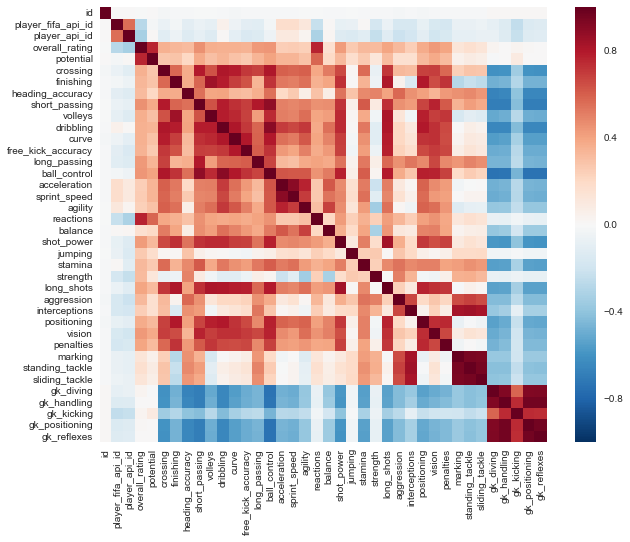

In [19]:
df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

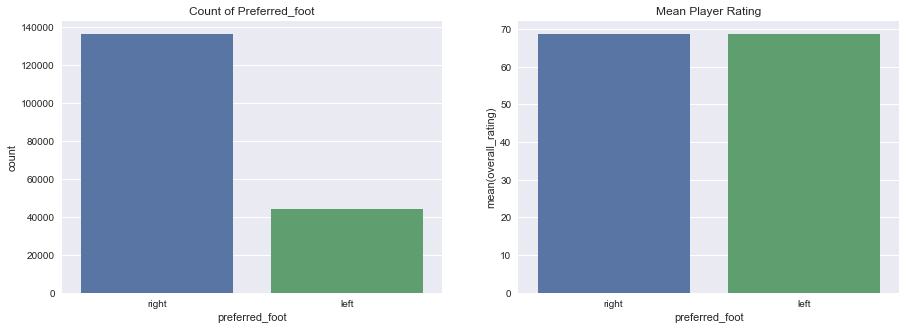

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(df.preferred_foot)
plt.title('Count of Preferred_foot')

plt.subplot(1,2,2)
sns.barplot(x='preferred_foot', y='overall_rating', data=df, estimator=np.mean)
plt.title('Mean Player Rating')


#### Visual analysis shows that 'preferred_foot' may NOT be relevant independent variable to predict the player rating

In [21]:
df.drop('preferred_foot',axis=1, inplace=True)

#### Likewise, date field will not make sense in Linear Regression, so delete it

In [22]:
df.drop('date',axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 40 columns):
id                     180354 non-null int64
player_fifa_api_id     180354 non-null int64
player_api_id          180354 non-null int64
overall_rating         180354 non-null float64
potential              180354 non-null float64
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
acceleration           180354 non-null float64
sprint_speed           180354 non-null float64
agil

#### This results in only 2 CATEGORICAL COLUMNS to deal with

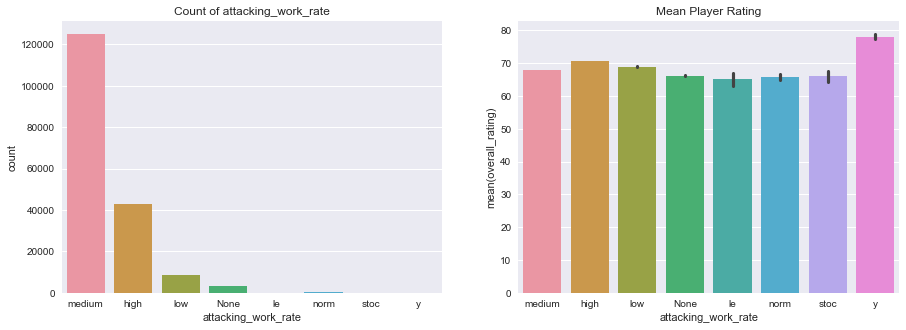

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(df.attacking_work_rate)
plt.title('Count of attacking_work_rate')

plt.subplot(1,2,2)
sns.barplot(x='attacking_work_rate', y='overall_rating', data=df, estimator=np.mean)
plt.title('Mean Player Rating')

#### Visual analysis shows that 'attacking_work_rate' may be a relevant independent variable

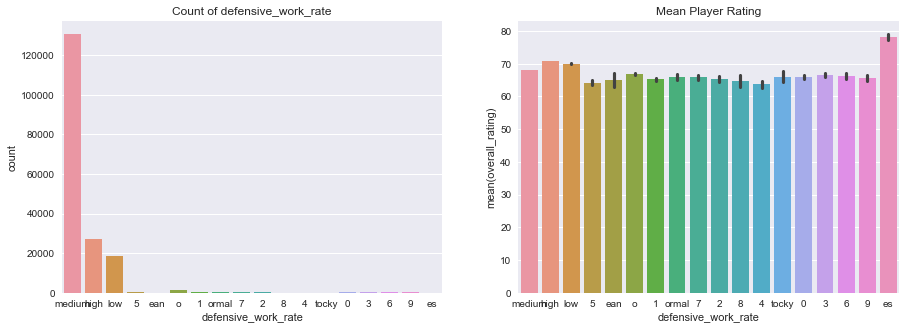

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.countplot(df.defensive_work_rate)
plt.title('Count of defensive_work_rate')

plt.subplot(1,2,2)
sns.barplot(x='defensive_work_rate', y='overall_rating', data=df, estimator=np.mean)
plt.title('Mean Player Rating')

#### Also, it seems like "defensive_work_rate' could be a relevant independent variable to consider

#### CONVERT CATEGORICAL COLUMNS INTO NUMERIC USING DUMMIES

In [26]:
df_dummies1 = pd.get_dummies(df.attacking_work_rate, drop_first=True, prefix='dum_attack')
df_dummies2 = pd.get_dummies(df.defensive_work_rate, drop_first=True, prefix='dum_defense')


In [27]:
df = df.drop('attacking_work_rate', axis=1).join(df_dummies1)
df = df.drop('defensive_work_rate', axis=1).join(df_dummies2)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 62 columns):
id                    180354 non-null int64
player_fifa_api_id    180354 non-null int64
player_api_id         180354 non-null int64
overall_rating        180354 non-null float64
potential             180354 non-null float64
crossing              180354 non-null float64
finishing             180354 non-null float64
heading_accuracy      180354 non-null float64
short_passing         180354 non-null float64
volleys               180354 non-null float64
dribbling             180354 non-null float64
curve                 180354 non-null float64
free_kick_accuracy    180354 non-null float64
long_passing          180354 non-null float64
ball_control          180354 non-null float64
acceleration          180354 non-null float64
sprint_speed          180354 non-null float64
agility               180354 non-null float64
reactions             180354 non-null float64
balance              

#### Now, they are ALL NUMERIC COLUMNS; we can go ahead with Linear Regression

##### Separate dataset into Dependent and Independent variables

In [29]:
X = df.drop('overall_rating',axis=1)
Y = df['overall_rating']


##### Split into Train and Test datasets

In [30]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state= 10)

In [31]:
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
model = sm.OLS(train_y, train_x).fit()

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.570e+04
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:50:37   Log-Likelihood:            -3.4341e+05
No. Observations:              144283   AIC:                         6.869e+05
Df Residuals:                  144225   BIC:                         6.875e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6997      0.238      2.939      0.003       0.233       1.166
id                   1.53e-07    1.3e-07      1.176      0.239   -1.02e-07    4.08e-07
player_fifa_api_id -8.619e-06    1.7e-07    -50.650      0.000   -8.95e-06   -8.29e-06
player_api_id      -6.395e-06   6.85e-08    -93.346      0.000   -6.53e-06   -6.26e-06
potential              0.4472      0.002    274.043      0.000       0.444       0.450
crossing               0.0067      0.001      7.525      0.000       0.005       0.008
finishing              0.0144      0.001     14.873      0.000       0.013       0.016
heading_accuracy       0.0558      0.001     64.488      0.000       0.054       0.057
short_passing          0.0564      0.001     38.766      0.000       0.054       0.059
volleys               -0.0068      0.001     -7.803      0.000      -0.008      -0.005
dribbling              0.0093      0.001      7.514      0.000       0.007       0.012
curve                  0.0122      0.001     14.499      0.000       0.011       0.014
free_kick_accuracy     0.0074      0.001      9.819      0.000       0.006       0.009
long_passing           0.0106      0.001     10.679      0.000       0.009       0.013
ball_control           0.1112      0.002     66.283      0.000       0.108       0.115
acceleration           0.0117      0.001      8.030      0.000       0.009       0.015
sprint_speed           0.0153      0.001     11.101      0.000       0.013       0.018
agility               -0.0107      0.001    -10.043      0.000      -0.013      -0.009
reactions              0.1764      0.001    151.083      0.000       0.174       0.179
balance                0.0051      0.001      6.129      0.000       0.003       0.007
shot_power             0.0133      0.001     14.468      0.000       0.012       0.015
jumping                0.0113      0.001     14.774      0.000       0.010       0.013
stamina               -0.0021      0.001     -2.372      0.018      -0.004      -0.000
strength               0.0509      0.001     57.390      0.000       0.049       0.053
long_shots            -0.0111      0.001    -11.568      0.000      -0.013      -0.009
aggression             0.0106      0.001     14.535      0.000       0.009       0.012
interceptions          0.0039      0.001      5.027      0.000       0.002       0.005
positioning           -0.0061      0.001     -7.343      0.000      -0.008      -0.004
vision                -0.0185      0.001    -19.943      0.000      -0.020      -0.017
penalties              0.0093      0.001     11.790      0.000       0.008       0.011
marking                0.0260      0.001     21.967      0.000       0.024       0.028
standing_tackle        0.0067      0.001      4.894      0.000       0.004       0.009
sliding_tackle        -0.0185      0.0

##### Linear Regression model results show Adj-R-squared = 86%, which is quite good
##### The p-values for a few columns are > 5%.... so, we can remove them from the model
##### The columns are: id, dum_attack_medium, dum_defense_3, dum_defense_5, dum_defense_6, dum_defense_7 dum_defense_8
##### dum_defense_9, dum_defense_high, dum_defense_low 

In [35]:
X_new = df.drop(['overall_rating','id','dum_attack_medium', 'dum_defense_3', 'dum_defense_5', 'dum_defense_6', 'dum_defense_7', 'dum_defense_8', 'dum_defense_9','dum_defense_high', 'dum_defense_low'], axis = 1)
Y_new = df['overall_rating']

##### New, re-run the model with reduced variables

In [36]:
train_x, test_x, train_y, test_y = train_test_split(X_new, Y_new, test_size=0.2, random_state= 10)
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
model = sm.OLS(train_y, train_x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.904e+04
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:59:05   Log-Likelihood:            -3.4344e+05
No. Observations:              144283   AIC:                         6.870e+05
Df Residuals:                  144235   BIC:                         6.874e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7338      0.108      6.818      0.000       0.523       0.945
player_fifa_api_id -8.622e-06    1.7e-07    -50.672      0.000   -8.96e-06   -8.29e-06
player_api_id      -6.415e-06   6.84e-08    -93.740      0.000   -6.55e-06   -6.28e-06
potential              0.4474      0.002    274.329      0.000       0.444       0.451
crossing               0.0068      0.001      7.671      0.000       0.005       0.009
finishing              0.0143      0.001     14.760      0.000       0.012       0.016
heading_accuracy       0.0559      0.001     64.688      0.000       0.054       0.058
short_passing          0.0561      0.001     38.609      0.000       0.053       0.059
volleys               -0.0069      0.001     -7.941      0.000      -0.009      -0.005
dribbling              0.0094      0.001      7.564      0.000       0.007       0.012
curve                  0.0124      0.001     14.736      0.000       0.011       0.014
free_kick_accuracy     0.0075      0.001     10.003      0.000       0.006       0.009
long_passing           0.0106      0.001     10.676      0.000       0.009       0.013
ball_control           0.1117      0.002     66.589      0.000       0.108       0.115
acceleration           0.0118      0.001      8.102      0.000       0.009       0.015
sprint_speed           0.0155      0.001     11.256      0.000       0.013       0.018
agility               -0.0107      0.001     -9.992      0.000      -0.013      -0.009
reactions              0.1764      0.001    151.050      0.000       0.174       0.179
balance                0.0050      0.001      6.024      0.000       0.003       0.007
shot_power             0.0133      0.001     14.443      0.000       0.012       0.015
jumping                0.0112      0.001     14.596      0.000       0.010       0.013
stamina               -0.0027      0.001     -3.128      0.002      -0.004      -0.001
strength               0.0510      0.001     57.521      0.000       0.049       0.053
long_shots            -0.0112      0.001    -11.644      0.000      -0.013      -0.009
aggression             0.0102      0.001     14.138      0.000       0.009       0.012
interceptions          0.0038      0.001      4.888      0.000       0.002       0.005
positioning           -0.0061      0.001     -7.261      0.000      -0.008      -0.004
vision                -0.0187      0.001    -20.111      0.000      -0.020      -0.017
penalties              0.0095      0.001     12.014      0.000       0.008       0.011
marking                0.0258      0.001     21.805      0.000       0.023       0.028
standing_tackle        0.0066      0.001      4.815      0.000       0.004       0.009
sliding_tackle        -0.0188      0.001    -16.221      0.000      -0.021      -0.017
gk_diving              0.1578      0.0

##### Now, all the p-values are < 5%, and the R-sq and Adj-Rsq are 86%

In [37]:
lm = LinearRegression()
model = lm.fit(train_x.values, train_y.values)
print ("Train score",model.score(train_x, train_y))
print ("Test score",model.score(test_x, test_y))


Train score 0.861187288367
Test score 0.858814805512


##### Both Train and Test scores for Linear Regression fit are consistent, and quite good from a modeling perspective

In [38]:
train_pred_y = model.predict(train_x)
test_pred_y = model.predict(test_x)
print('RMSE Train', math.sqrt(mean_squared_error(train_pred_y, train_y)))
print('RMSE Test' ,math.sqrt(mean_squared_error(test_pred_y, test_y)))
print ('************')
print ("Mean Player Rating",df.overall_rating.mean())

RMSE Train 2.615251826376897
RMSE Test 2.653512465364589
************
Mean Player Rating 68.63531720948801


##### The RMSE is very low as compared to the Mean rating... again, confirms that the Linear Regression model is working well

#### MODEL EVALUATION

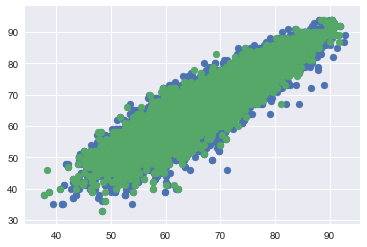

In [39]:
plt.scatter(train_pred_y, train_y)
plt.scatter(test_pred_y, test_y)

##### Close to a straight line ... acceptably ok

(array([  5.00000000e+00,   1.80000000e+01,   2.90000000e+01,
          1.78000000e+02,   8.30000000e+02,   3.08600000e+03,
          7.78300000e+03,   1.11090000e+04,   7.83200000e+03,
          3.27600000e+03,   1.18700000e+03,   4.27000000e+02,
          1.93000000e+02,   6.00000000e+01,   3.50000000e+01,
          1.20000000e+01,   5.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   3.00000000e+00]),
 array([-13.76817911, -11.96216057, -10.15614203,  -8.35012348,
         -6.54410494,  -4.7380864 ,  -2.93206785,  -1.12604931,
          0.67996924,   2.48598778,   4.29200632,   6.09802487,
          7.90404341,   9.71006195,  11.5160805 ,  13.32209904,
         15.12811758,  16.93413613,  18.74015467,  20.54617321,  22.35219176]),
 <a list of 20 Patch objects>)

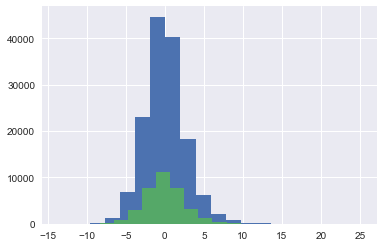

In [40]:
# Checking for normality

plt.hist(train_pred_y - train_y, bins=20)
plt.hist(test_pred_y - test_y, bins=20)

#### Visual analysis shows that the distribution is close to normal

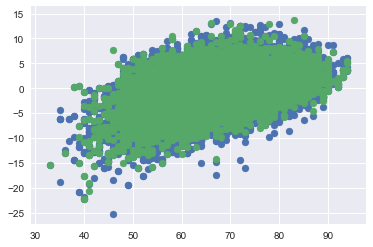

In [41]:
plt.scatter(train_y, train_y - train_pred_y)
plt.scatter(test_y, test_y - test_pred_y)

#### Scatter plot is dispersed around zero, but it is not perfectly random.

#### CROSS VALIDATION OF MODEL

In [43]:
scores = cross_val_score(model, X_new, Y_new, cv=10, scoring='neg_mean_squared_error')

print("Cross-validated scores:", scores)

Cross-validated scores: [-6.85974282 -6.77572824 -6.82491176 -7.1694302  -6.83361376 -7.33883279
 -6.74935187 -6.86900432 -6.92677298 -6.78390545]


#### Each run's score is very close to the other

#### MODEL FINE-TUNING

In [44]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

vif.sort_values(by='VIF Factor' ,ascending=False)


C:\Users\krishnam\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
50,inf,dum_defense_tocky
37,inf,dum_attack_le
39,inf,dum_attack_norm
40,inf,dum_attack_stoc
49,inf,dum_defense_ormal
46,inf,dum_defense_es
45,inf,dum_defense_ean
41,inf,dum_attack_y
2,283.61,potential
12,251.97,ball_control


##### There are many factors with VIF > 10, we may drop them and then re-run the model
##### Based on VIF scores, we may at least delete the ones with VIF = infinity
##### dum_defense_tocky, dum_attack_le, dum_attack_norm, dum_attack_stoc, dum_defense_ormal, dum_defense_es, dum_defense_ean, dum_attack_y


In [46]:
X_tune1 = X_new.drop(['dum_defense_tocky','dum_attack_le', 'dum_attack_norm', 'dum_attack_stoc', 'dum_defense_ormal', 'dum_defense_es', 'dum_defense_ean', 'dum_attack_y'], axis = 1)


In [47]:
train_x, test_x, train_y, test_y = train_test_split(X_tune1, Y_new, test_size=0.2, random_state= 10)

In [48]:
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
model = sm.OLS(train_y, train_x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 2.079e+04
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:12:12   Log-Likelihood:            -3.4350e+05
No. Observations:              144283   AIC:                         6.871e+05
Df Residuals:                  144239   BIC:                         6.875e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6847      0.108      6.368      0.000       0.474       0.895
player_fifa_api_id -8.558e-06    1.7e-07    -50.331      0.000   -8.89e-06   -8.22e-06
player_api_id      -6.415e-06   6.84e-08    -93.722      0.000   -6.55e-06   -6.28e-06
potential              0.4473      0.002    274.255      0.000       0.444       0.450
crossing               0.0068      0.001      7.644      0.000       0.005       0.009
finishing              0.0142      0.001     14.679      0.000       0.012       0.016
heading_accuracy       0.0559      0.001     64.623      0.000       0.054       0.058
short_passing          0.0562      0.001     38.662      0.000       0.053       0.059
volleys               -0.0067      0.001     -7.688      0.000      -0.008      -0.005
dribbling              0.0094      0.001      7.599      0.000       0.007       0.012
curve                  0.0125      0.001     14.814      0.000       0.011       0.014
free_kick_accuracy     0.0073      0.001      9.808      0.000       0.006       0.009
long_passing           0.0107      0.001     10.801      0.000       0.009       0.013
ball_control           0.1117      0.002     66.604      0.000       0.108       0.115
acceleration           0.0117      0.001      8.070      0.000       0.009       0.015
sprint_speed           0.0154      0.001     11.192      0.000       0.013       0.018
agility               -0.0107      0.001     -9.993      0.000      -0.013      -0.009
reactions              0.1765      0.001    151.181      0.000       0.174       0.179
balance                0.0050      0.001      6.112      0.000       0.003       0.007
shot_power             0.0134      0.001     14.486      0.000       0.012       0.015
jumping                0.0113      0.001     14.731      0.000       0.010       0.013
stamina               -0.0027      0.001     -3.095      0.002      -0.004      -0.001
strength               0.0511      0.001     57.668      0.000       0.049       0.053
long_shots            -0.0112      0.001    -11.666      0.000      -0.013      -0.009
aggression             0.0102      0.001     14.044      0.000       0.009       0.012
interceptions          0.0037      0.001      4.772      0.000       0.002       0.005
positioning           -0.0062      0.001     -7.381      0.000      -0.008      -0.005
vision                -0.0188      0.001    -20.214      0.000      -0.021      -0.017
penalties              0.0095      0.001     11.965      0.000       0.008       0.011
marking                0.0256      0.001     21.679      0.000       0.023       0.028
standing_tackle        0.0067      0.001      4.864      0.000       0.004       0.009
sliding_tackle        -0.0187      0.001    -16.137      0.000      -0.021      -0.016
gk_diving              0.1581      0.0

In [49]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_tune1.values, i) for i in range(X_tune1.shape[1])]
vif["features"] = X_tune1.columns

vif.sort_values(by='VIF Factor' ,ascending=False)

,VIF Factor,features
2,283.39,potential
12,251.96,ball_control
13,211.49,acceleration
14,191.71,sprint_speed
6,181.45,short_passing
16,127.82,reactions
8,123.14,dribbling
29,118.06,standing_tackle
15,107.17,agility
30,78.90,sliding_tackle


##### We may attempt to remove a few more variables based on high VIF scores
##### For the first run we can eliminate the 3 variables above 200 score
##### potential, ball_control, acceleration 

In [53]:
X_tune2 = X_tune1.drop(['potential','ball_control', 'acceleration'], axis = 1)
train_x, test_x, train_y, test_y = train_test_split(X_tune2, Y_new, test_size=0.2, random_state= 10)
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
model = sm.OLS(train_y, train_x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                 1.197e+04
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:20:33   Log-Likelihood:            -3.8033e+05
No. Observations:              144283   AIC:                         7.608e+05
Df Residuals:                  144242   BIC:                         7.612e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.6850      0.133     72.564      0.000       9.423       9.947
player_fifa_api_id -5.778e-06   2.19e-07    -26.437      0.000   -6.21e-06   -5.35e-06
player_api_id      -1.021e-06   8.49e-08    -12.036      0.000   -1.19e-06   -8.55e-07
crossing              -0.0166      0.001    -14.530      0.000      -0.019      -0.014
finishing              0.0139      0.001     11.095      0.000       0.011       0.016
heading_accuracy       0.1053      0.001     96.239      0.000       0.103       0.107
short_passing          0.1511      0.002     86.243      0.000       0.148       0.155
volleys               -0.0040      0.001     -3.533      0.000      -0.006      -0.002
dribbling              0.0673      0.001     45.927      0.000       0.064       0.070
curve                  0.0218      0.001     20.125      0.000       0.020       0.024
free_kick_accuracy     0.0083      0.001      8.589      0.000       0.006       0.010
long_passing           0.0199      0.001     15.472      0.000       0.017       0.022
sprint_speed           0.0902      0.001     73.005      0.000       0.088       0.093
agility                0.0025      0.001      1.876      0.061      -0.000       0.005
reactions              0.2990      0.001    210.818      0.000       0.296       0.302
balance                0.0068      0.001      6.464      0.000       0.005       0.009
shot_power             0.0276      0.001     23.185      0.000       0.025       0.030
jumping                0.0097      0.001      9.817      0.000       0.008       0.012
stamina               -0.0138      0.001    -12.424      0.000      -0.016      -0.012
strength               0.0612      0.001     53.634      0.000       0.059       0.063
long_shots            -0.0222      0.001    -17.883      0.000      -0.025      -0.020
aggression             0.0052      0.001      5.576      0.000       0.003       0.007
interceptions          0.0143      0.001     14.257      0.000       0.012       0.016
positioning           -0.0126      0.001    -11.685      0.000      -0.015      -0.010
vision                 0.0120      0.001     10.078      0.000       0.010       0.014
penalties              0.0191      0.001     18.789      0.000       0.017       0.021
marking                0.0303      0.002     19.866      0.000       0.027       0.033
standing_tackle        0.0158      0.002      8.949      0.000       0.012       0.019
sliding_tackle        -0.0285      0.001    -19.044      0.000      -0.031      -0.026
gk_diving              0.1890      0.002     95.744      0.000       0.185       0.193
gk_handling            0.0486      0.003     18.687      0.000       0.043       0.054
gk_kicking            -0.0324      0.001    -37.967      0.000      -0.034      -0.031
gk_positioning         0.0679      0.0

##### Any further removal of independent variables using VIF score is impacting the overall R-squared value
#### We may stop the modeling exercise at this point
#### Given better R-squared and Adj-R-sq values were achieved with X_tune1 dataset, we can decide to pick that as the final model

In [54]:
train_x, test_x, train_y, test_y = train_test_split(X_tune1, Y_new, test_size=0.2, random_state= 10)

In [55]:
lm = LinearRegression()
model = lm.fit(train_x.values, train_y.values)
print ("Train score",model.score(train_x, train_y))
print ("Test score",model.score(test_x, test_y))

Train score 0.861067835427
Test score 0.858757237872


In [56]:
model.coef_

array([ -8.55763066e-06,  -6.41523249e-06,   4.47271981e-01,
         6.81091235e-03,   1.42450012e-02,   5.58782382e-02,
         5.61908921e-02,  -6.68244625e-03,   9.39830154e-03,
         1.24715812e-02,   7.34309840e-03,   1.07476389e-02,
         1.11734106e-01,   1.17256319e-02,   1.54489561e-02,
        -1.06884628e-02,   1.76544912e-01,   5.04744470e-03,
         1.33682897e-02,   1.13109198e-02,  -2.67508896e-03,
         5.11255133e-02,  -1.12370370e-02,   1.01758755e-02,
         3.72095876e-03,  -6.16223756e-03,  -1.87544563e-02,
         9.45834100e-03,   2.56105896e-02,   6.65157087e-03,
        -1.87041114e-02,   1.58111335e-01,   2.54029263e-02,
        -4.67246623e-02,   4.71733456e-02,   1.94802290e-02,
         1.56104708e-01,   1.00230132e+00,   7.33995042e-01,
        -3.79673669e-01,  -6.60235663e-01,  -3.04951508e-01,
        -8.66673023e-01])

In [57]:
model.intercept_

0.68471960730974502